##Загрузка всякого

In [ ]:
!pip install scikit-plot

In [33]:
import numpy as np 
import pandas as pd
import math
import numpy as np
import pandas as pd
import os
import cv2

import scikitplot
import seaborn as sns
from matplotlib import pyplot

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report

import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential, load_model, save_model
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dropout, BatchNormalization, LeakyReLU, Activation
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau, CSVLogger
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.utils.vis_utils import plot_model

from keras.utils import np_utils

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


In [4]:
csv_path = '/content/drive/MyDrive/zxc/fer2013.csv'
df = pd.read_csv(csv_path)
print(df.shape)
df.head()

(35887, 3)


,emotion,pixels,Usage
0,0,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...,Training
1,0,151 150 147 155 148 133 111 140 170 174 182 15...,Training
2,2,231 212 156 164 174 138 161 173 182 200 106 38...,Training
3,4,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...,Training
4,6,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...,Training


##Смотрим на датасет

In [6]:
emotion_label_to_text = {0:'anger', 1:'disgust', 2:'fear', 3:'happiness', 4: 'sadness', 5: 'surprise', 6: 'neutral'}

In [7]:
df.emotion.value_counts()

3    8989
6    6198
4    6077
2    5121
0    4953
5    4002
1     547
Name: emotion, dtype: int64

<Axes: xlabel='emotion', ylabel='count'>

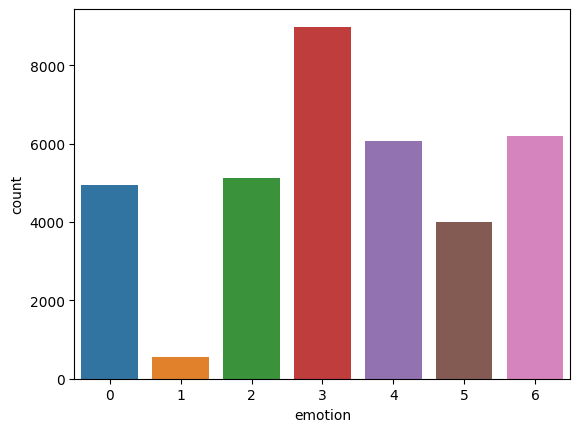

In [8]:
sns.countplot(x=df.emotion)

Таким образом, большинство классов относится к 3:Happy, 4:Sad и 6:Neutral, и нас также интересуют только эти три класса.

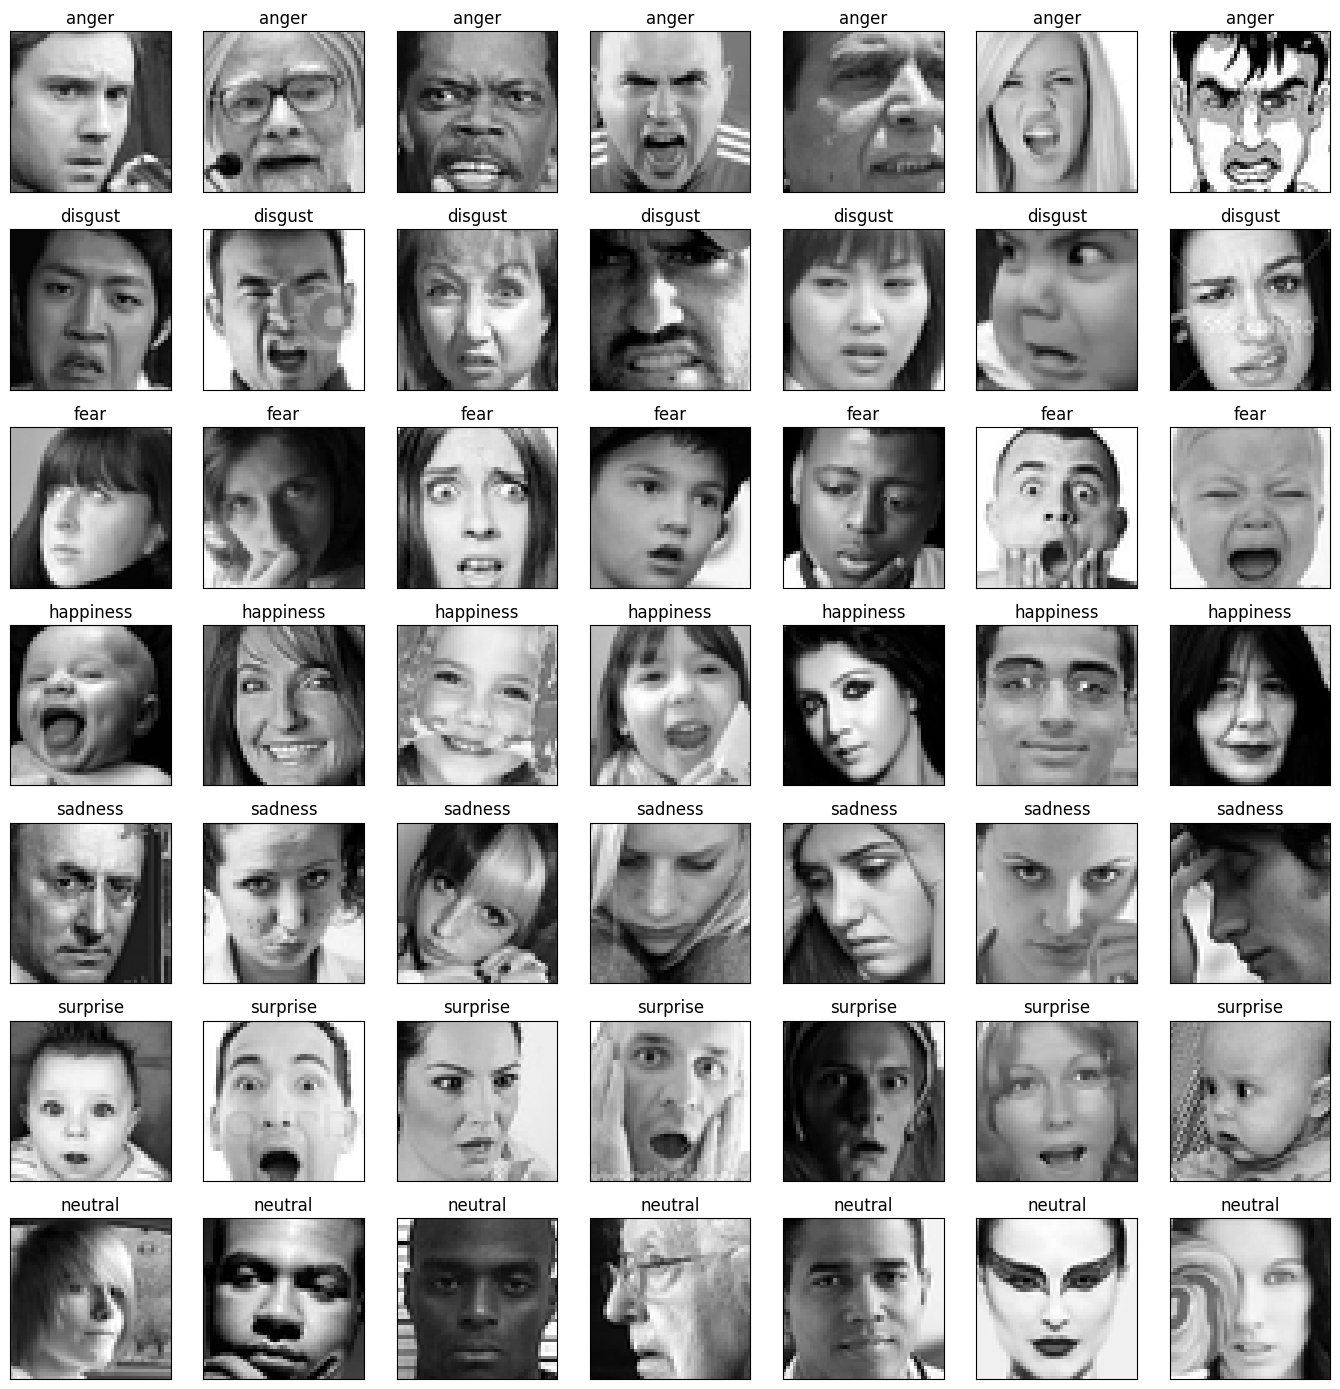

In [9]:
fig = pyplot.figure(1, (14, 14))

k = 0
for label in sorted(df.emotion.unique()):
    for j in range(7):
        px = df[df.emotion==label].pixels.iloc[k]
        px = np.array(px.split(' ')).reshape(48, 48).astype('float32')

        k += 1
        ax = pyplot.subplot(7, 7, k)
        ax.imshow(px, cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(emotion_label_to_text[label])
        pyplot.tight_layout()

In [10]:
INTERESTED_LABELS = [3, 4, 6]

In [11]:
df = df[df.emotion.isin(INTERESTED_LABELS)]
df.shape

(21264, 3)

## Подготовка данных

In [12]:
img_array = df.pixels.apply(lambda x: np.array(x.split(' ')).reshape(48, 48, 1).astype('float32'))
img_array = np.stack(img_array, axis=0)

In [13]:
img_array.shape

(21264, 48, 48, 1)

In [14]:
le = LabelEncoder()
img_labels = le.fit_transform(df.emotion)
img_labels = np_utils.to_categorical(img_labels)
img_labels.shape

(21264, 3)

In [15]:
le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
print(le_name_mapping)

{3: 0, 4: 1, 6: 2}


Разделение данных на обучающее и проверочное множество.

In [16]:
X_train, X_valid, y_train, y_valid = train_test_split(img_array, img_labels,
                                                    shuffle=True, stratify=img_labels,
                                                    test_size=0.1, random_state=42)
X_train.shape, X_valid.shape, y_train.shape, y_valid.shape

((19137, 48, 48, 1), (2127, 48, 48, 1), (19137, 3), (2127, 3))

In [17]:
del df
del img_array
del img_labels

In [18]:
img_width = X_train.shape[1]
img_height = X_train.shape[2]
img_depth = X_train.shape[3]
num_classes = y_train.shape[1]

In [19]:
X_train = X_train / 255.
X_valid = X_valid / 255.

## Определяем сеточку

In [20]:
def build_net(optim):
    """
    This is a Deep Convolutional Neural Network (DCNN).
    """
    net = Sequential(name='DCNN')

    net.add(
        Conv2D(
            filters=64,
            kernel_size=(5,5),
            input_shape=(img_width, img_height, img_depth),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_1'
        )
    )
    net.add(BatchNormalization(name='batchnorm_1'))
    net.add(
        Conv2D(
            filters=64,
            kernel_size=(5,5),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_2'
        )
    )
    net.add(BatchNormalization(name='batchnorm_2'))
    
    net.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_1'))
    net.add(Dropout(0.4, name='dropout_1'))

    net.add(
        Conv2D(
            filters=128,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_3'
        )
    )
    net.add(BatchNormalization(name='batchnorm_3'))
    net.add(
        Conv2D(
            filters=128,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_4'
        )
    )
    net.add(BatchNormalization(name='batchnorm_4'))
    
    net.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_2'))
    net.add(Dropout(0.4, name='dropout_2'))

    net.add(
        Conv2D(
            filters=256,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_5'
        )
    )
    net.add(BatchNormalization(name='batchnorm_5'))
    net.add(
        Conv2D(
            filters=256,
            kernel_size=(3,3),
            activation='elu',
            padding='same',
            kernel_initializer='he_normal',
            name='conv2d_6'
        )
    )
    net.add(BatchNormalization(name='batchnorm_6'))
    
    net.add(MaxPooling2D(pool_size=(2,2), name='maxpool2d_3'))
    net.add(Dropout(0.5, name='dropout_3'))

    net.add(Flatten(name='flatten'))
        
    net.add(
        Dense(
            128,
            activation='elu',
            kernel_initializer='he_normal',
            name='dense_1'
        )
    )
    net.add(BatchNormalization(name='batchnorm_7'))
    
    net.add(Dropout(0.6, name='dropout_4'))
    
    net.add(
        Dense(
            num_classes,
            activation='softmax',
            name='out_layer'
        )
    )
    
    net.compile(
        loss='categorical_crossentropy',
        optimizer=optim,
        metrics=['accuracy']
    )
    
    net.summary()
    
    return net

In [21]:
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    min_delta=0.00005,
    patience=11,
    verbose=1,
    restore_best_weights=True,
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,
    patience=7,
    min_lr=1e-7,
    verbose=1,
)

logger = CSVLogger(
    '/content/drive/MyDrive/zxc/history.csv',
    separator = ',',
    append = True
)

callbacks = [
    early_stopping,
    lr_scheduler,
    logger
]

In [22]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
)
train_datagen.fit(X_train)

In [23]:
optim = optimizers.Nadam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07, name='Nadam')

model_name = "/content/drive/MyDrive/zxc/my_model"
batch_size = 32

if os.path.exists(model_name):
  model = load_model(model_name)
  start = pd.read_csv('/content/drive/MyDrive/zxc/history.csv', sep=',')
  start = start['epoch'].iloc[-1]
else:
  model = build_net(optim)

zxc


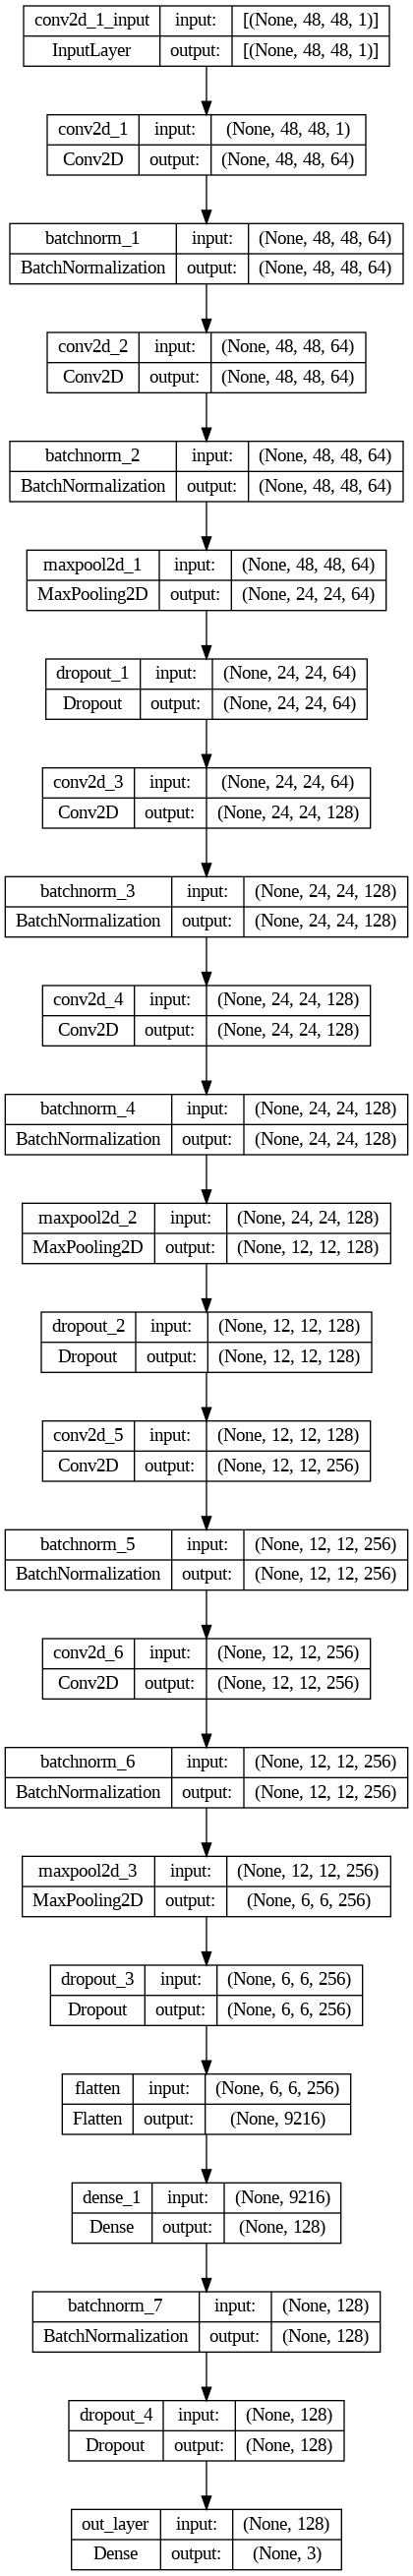

In [34]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

## Обучаем сеточку

In [ ]:
epochs = 20
history = model.fit(
    train_datagen.flow(X_train, y_train, batch_size=batch_size),
    validation_data=(X_valid, y_valid),
    steps_per_epoch=len(X_train) / batch_size,
    epochs=epochs,
    callbacks=callbacks,
    use_multiprocessing=True,
    initial=start
)

model.save(model_name)

##Картиночки

In [29]:
out = pd.read_csv('/content/drive/MyDrive/zxc/history.csv', sep=',')
out

,epoch,accuracy,loss,lr,val_accuracy,val_loss
0,0,0.404766,1.343997,0.001,0.524683,0.974314
1,0,0.497518,1.012025,0.001,0.573108,0.933493
2,1,0.551811,0.926244,0.001,0.622003,0.861062
3,0,0.601923,0.834949,0.001,0.687353,0.689408
4,1,0.653969,0.747104,0.001,0.693935,0.679562
5,2,0.679992,0.710739,0.001,0.722614,0.655891
6,3,0.699901,0.675015,0.001,0.716032,0.617969
7,4,0.712599,0.656567,0.001,0.756464,0.562791
8,5,0.725140,0.632965,0.001,0.779032,0.540538
9,6,0.730313,0.619952,0.001,0.738599,0.589948


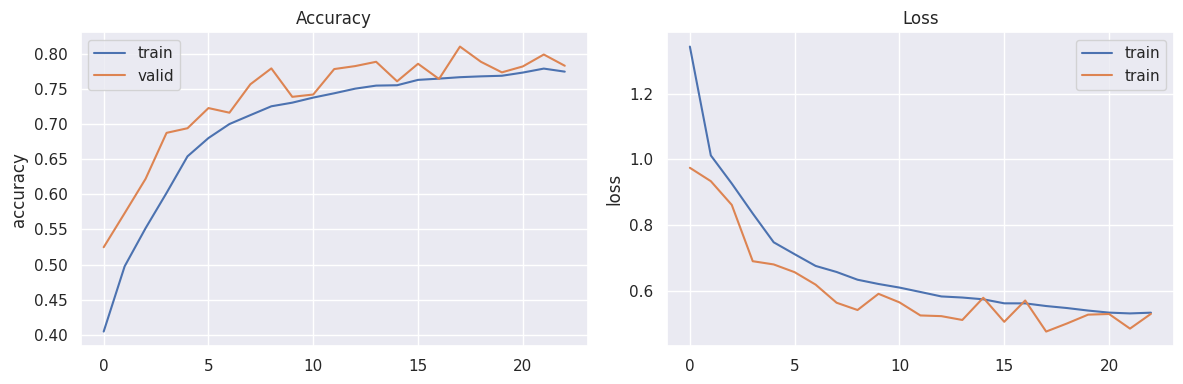

In [30]:
sns.set()
fig = pyplot.figure(0, (12, 4))

ax = pyplot.subplot(1, 2, 1)
sns.lineplot(x=[i for i in range(len(out))], y=out['accuracy'], label='train')
sns.lineplot(x=[i for i in range(len(out))], y=out['val_accuracy'], label='valid')
pyplot.title('Accuracy')
pyplot.tight_layout()

ax = pyplot.subplot(1, 2, 2)
sns.lineplot(x=[i for i in range(len(out))], y=out['loss'], label='train')
sns.lineplot(x=[i for i in range(len(out))], y=out['val_loss'], label='train')
pyplot.title('Loss')
pyplot.tight_layout()

pyplot.savefig('epoch_history_dcnn.png')
pyplot.show()

In [35]:
yhat_valid = model.predict(X_valid)
print(f'total wrong validation predictions: {np.sum(np.argmax(y_valid, axis=1) != np.argmax(yhat_valid, axis=1))} from {np.sum(np.argmax(y_valid, axis=1))}\n\n')
print(classification_report(np.argmax(y_valid, axis=1), np.argmax(yhat_valid, axis=1)))
scikitplot.metrics.confusion_matrix(np.argmax(y_valid, axis=1), np.argmax(yhat_valid, axis=1))

67/67 [==============================] - 33s 484ms/step
total wrong validation predictions: 462 from 1848


              precision    recall  f1-score   support

           0       0.83      0.95      0.89       899
           1       0.84      0.57      0.68       608
           2       0.68      0.75      0.71       620

    accuracy                           0.78      2127
   macro avg       0.78      0.76      0.76      2127
weighted avg       0.79      0.78      0.78      2127



array([[858,  11,  30],
       [ 75, 344, 189],
       [104,  53, 463]])

Confusion matrix ясно показывает, что наша модель хорошо справляется с классом `happy`, но ее производительность низка для двух других классов. Одной из причин этого может быть тот факт, что эти два класса содержат меньше данных. Но когда я просмотрел изображения, я обнаружил, что на некоторых изображениях из этих двух классов человеку даже трудно определить, грустный человек или нейтральный. Выражение лица также зависит от человека. У некоторых людей нейтральное лицо выглядит как грустное.

In [36]:
mapper = {
    0: "happy",
    1: "sad",
    2: "neutral",
}

1/1 [==============================] - 0s 45ms/step


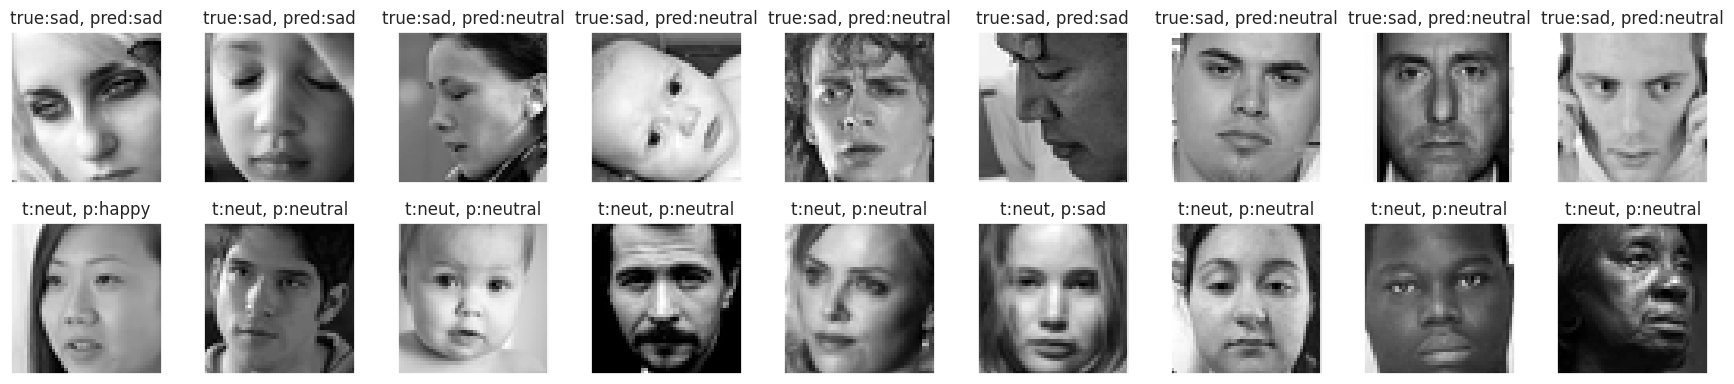

In [37]:
np.random.seed(2)
random_sad_imgs = np.random.choice(np.where(y_valid[:, 1]==1)[0], size=9)
random_neutral_imgs = np.random.choice(np.where(y_valid[:, 2]==1)[0], size=9)

fig = pyplot.figure(1, (18, 4))

for i, (sadidx, neuidx) in enumerate(zip(random_sad_imgs, random_neutral_imgs)):
        ax = pyplot.subplot(2, 9, i+1)
        sample_img = X_valid[sadidx,:,:,0]
        ax.imshow(sample_img, cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        pred = model.predict(sample_img.reshape(1,48,48,1))[0]
        ax.set_title(f"true:sad, pred:{mapper[np.argmax(pred)]}")

        ax = pyplot.subplot(2, 9, i+10)
        sample_img = X_valid[neuidx,:,:,0]
        ax.imshow(sample_img, cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        pred = model.predict(sample_img.reshape(1,48,48,1))[0]
        ax.set_title(f"t:neut, p:{mapper[np.argmax(pred)]}")

        pyplot.tight_layout()